In [34]:
from hcipy import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from astropy.io import fits

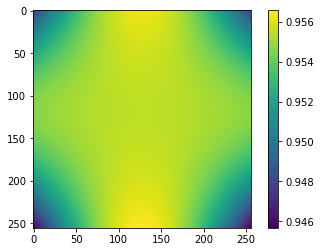

In [40]:
# Load Jones pupils
pth = '/Users/jashcraft/Library/CloudStorage/Box-Box/PolarizationGSMT/ELT/Jones_Pupils/'
band = 'V'

def load_jones(pth,band,pol):
    real = fits.getdata(pth+f'E{pol}r_{band}.fits')
    imag = fits.getdata(pth+f'E{pol}i_{band}.fits')
    return real + 1j*imag

Exx = load_jones(pth,band,'xx')
Exy = load_jones(pth,band,'xy')
Eyx = load_jones(pth,band,'yx')
Eyy = load_jones(pth,band,'yy')

plt.figure()
plt.imshow(np.abs(Exx))
plt.colorbar()
plt.show()

Exx = Exx.ravel()
Exy = Exy.ravel()
Eyx = Eyx.ravel()
Eyy = Eyy.ravel()

In [47]:
# Create grids
pupil_grid = make_pupil_grid(256, pupil_diameter * 1.2)
focal_grid = make_focal_grid(2, 16, spatial_resolution=spatial_resolution)
prop = FraunhoferPropagator(pupil_grid, focal_grid, focal_length)

# Set up a partially polarized wavefront
mask = np.exp(-(pupil_grid.as_('polar').r / (0.5 * pupil_diameter))**30)
aperture = Field(mask,pupil_grid)
jones_matrix = Field([[Exx*mask,Exy*mask],[Eyx*mask,Eyy*mask]],pupil_grid)
stokes_vector = [1,0,0,0]
partially_polarized_wavefront = Wavefront(jones_matrix, input_stokes_vector=stokes_vector)


In [55]:
# Input parameters
pupil_diameter = 7e-3 # m
wavelength = 700e-9 # m
focal_length = 500e-3 # m

num_actuators_across = 32
actuator_spacing = 1.05 / 32 * pupil_diameter
aberration_ptv = 0.02 * wavelength # m

epsilon = 1e-9

spatial_resolution = focal_length * wavelength / pupil_diameter
iwa = 2 * spatial_resolution
owa = 12 * spatial_resolution
offset = 1 * spatial_resolution

efc_loop_gain = 0.5

# Create aperture and dark zone
# aperture = Field(, pupil_grid)

dark_zone = circular_aperture(2 * owa)(focal_grid)
dark_zone -= circular_aperture(2 * iwa)(focal_grid)
dark_zone *= focal_grid.x > offset
dark_zone = dark_zone.astype(bool)

<ipython-input-55-30695729dd7f>:22: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  dark_zone = circular_aperture(2 * owa)(focal_grid)
<ipython-input-55-30695729dd7f>:23: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  dark_zone -= circular_aperture(2 * iwa)(focal_grid)


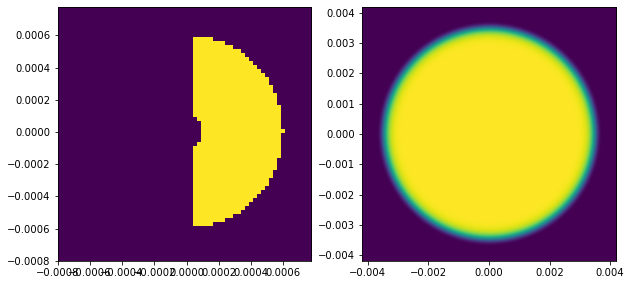

In [56]:
plt.figure(figsize=[10,5])
plt.subplot(121)
imshow_field(dark_zone)
plt.subplot(122)
imshow_field(aperture)
plt.show()

In [57]:
# Create optical elements
coronagraph = PerfectCoronagraph(aperture, order=6)

tip_tilt = make_zernike_basis(3, pupil_diameter, pupil_grid, starting_mode=2)
aberration = SurfaceAberration(pupil_grid, aberration_ptv, pupil_diameter, remove_modes=tip_tilt, exponent=-3)

influence_functions = make_gaussian_influence_functions(pupil_grid, num_actuators_across, actuator_spacing)
deformable_mirror = DeformableMirror(influence_functions)

/opt/anaconda3/lib/python3.8/site-packages/hcipy/optics/aberration.py:37: RuntimeWarning: divide by zero encountered in power
  res = Field(grid.as_('polar').r**exponent, grid)


In [93]:
def get_image(actuators=None, include_aberration=True):
    if actuators is not None:
        deformable_mirror.actuators = actuators

    wf = partially_polarized_wavefront #Wavefront(aperture, wavelength)
    # wf = Wavefront(aperture,wavelength)
    # wf_xx = Wavefront(aperture*(Exx + Exy),wavelength)
    # wf_xy = Wavefront(aperture*Exy,wavelength)
    # wf_yx = Wavefront(aperture*Eyx,wavelength)
    # wf_yy = Wavefront(aperture*Eyy,wavelength)

    if include_aberration:
        wf = aberration(wf)
        # wf_xy = aberration(wf_xy)
        # wf_yx = aberration(wf_yx)
        # wf_yy = aberration(wf_yy)
    img = prop(coronagraph(deformable_mirror(wf)))
    # img_xx = prop(coronagraph(deformable_mirror(wf_xx)))
    # img_xy = prop(coronagraph(deformable_mirror(wf_xy)))
    # img_yx = prop(coronagraph(deformable_mirror(wf_yx)))
    # img_yy = prop(coronagraph(deformable_mirror(wf_yy)))

    return img

img_ref = prop(Wavefront(aperture, wavelength)).intensity

In [102]:
def get_jacobian_matrix(get_image, dark_zone, num_modes):
    responses = []
    amps = np.linspace(-epsilon, epsilon, 2)

    for i, mode in enumerate(np.eye(num_modes)):
        response = 0

        for amp in amps:
            response += amp * get_image(mode * amp, include_aberration=True).electric_field

        response /= np.var(amps)
        response = response[...,dark_zone]

        responses.append(np.concatenate((response.real, response.imag)))

    jacobian = np.array(responses).T
    return jacobian

jacobian = get_jacobian_matrix(get_image, dark_zone, len(influence_functions))
print(jacobian.shape)


(813, 2, 4, 1024)


In [103]:
# print(len(influence_functions))
# print(dark_zone.shape)
# jacobian = np.moveaxis(jacobian,0,-1)[0,0]
# print(jacobian.shape)

1024
(4096,)
(1024, 813)


In [104]:
def run_efc(get_image, dark_zone, num_modes, jacobian, rcond=1e-2):
    
    # Calculate EFC matrix
    efc_matrix = inverse_tikhonov(jacobian, rcond)

    # Run EFC loop
    current_actuators = np.zeros(num_modes)

    actuators = []
    electric_fields = []
    images = []

    for i in range(50):
        img = get_image(current_actuators)

        electric_field = img.electric_field
        image = img.intensity

        actuators.append(current_actuators.copy())
        electric_fields.append(electric_field)
        images.append(image)

        x = np.concatenate((electric_field[dark_zone].real, electric_field[dark_zone].imag))
        y = efc_matrix.dot(x)

        current_actuators -= efc_loop_gain * y

    return actuators, electric_fields, images

actuators, electric_fields, images = run_efc(get_image, dark_zone, len(influence_functions), jacobian)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2 but corresponding boolean dimension is 4096

In [78]:
def make_animation_1dm(actuators, electric_fields, images, dark_zone):
    anim = FFMpegWriter('video.mp4', framerate=5)

    num_iterations = len(actuators)
    average_contrast = [np.mean(image[dark_zone] / img_ref.max()) for image in images]

    electric_field_norm = mpl.colors.LogNorm(10**-5, 10**(-2.5), True)

    for i in range(num_iterations):
        plt.clf()

        plt.subplot(2, 2, 1)
        plt.title('Electric field')
        electric_field = electric_fields[i] / np.sqrt(img_ref.max())
        imshow_field(electric_field, norm=electric_field_norm, grid_units=spatial_resolution)
        contour_field(dark_zone, grid_units=spatial_resolution, levels=[0.5], colors='white')

        plt.subplot(2, 2, 2)
        plt.title('Intensity image')
        imshow_field(np.log10(images[i] / img_ref.max()), grid_units=spatial_resolution, cmap='inferno', vmin=-10, vmax=-5)
        plt.colorbar()
        contour_field(dark_zone, grid_units=spatial_resolution, levels=[0.5], colors='white')

        plt.subplot(2, 2, 3)
        deformable_mirror.actuators = actuators[i]
        plt.title('DM surface in nm')
        imshow_field(deformable_mirror.surface * 1e9, grid_units=pupil_diameter, mask=aperture, cmap='RdBu', vmin=-5, vmax=5)
        plt.colorbar()

        plt.subplot(2, 2, 4)
        plt.title('Average contrast')
        plt.plot(range(i), average_contrast[:i], 'o-')
        plt.xlim(0, num_iterations)
        plt.yscale('log')
        plt.ylim(1e-15, 1e-5)
        plt.grid(color='0.5')

        plt.suptitle('Iteration %d / %d' % (i + 1, num_iterations), fontsize='x-large')

        anim.add_frame()

    plt.close()
    anim.close()

    return anim

make_animation_1dm(actuators, electric_fields, images, dark_zone)

In [73]:
 wf_xx = Wavefront(aperture*(Exx),wavelength)

In [81]:
partially_polarized_wavefront.electric_field.shape

(2, 2, 65536)